In [2]:
#@title Imports
import jax
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# The default of float16 can lead to discrepancies between outputs of
# the compiled model and the RASP program.
jax.config.update('jax_default_matmul_precision', 'float32')

from tracr.compiler import compiling
from tracr.compiler import lib
from tracr.rasp import rasp

In [3]:

#@title Plotting functions
def tidy_label(label, value_width=5):
  if ':' in label:
    label, value = label.split(':')
  else:
    value = ''
  return label + f":{value:>{value_width}}"


def add_residual_ticks(model, value_width=5, x=False, y=True):
  if y:
    plt.yticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            fontsize=20,
    )
  if x:
    plt.xticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            rotation=90,
            fontsize=20,
    )


def plot_computation_trace(model,
                           input_labels,
                           residuals_or_outputs,
                           add_input_layer=False,
                           figsize=(12, 9)):
  fig, axes = plt.subplots(nrows=1, ncols=len(residuals_or_outputs), figsize=figsize, sharey=True)
  value_width = max(map(len, map(str, input_labels))) + 1

  for i, (layer, ax) in enumerate(zip(residuals_or_outputs, axes)):
    plt.sca(ax)
    plt.pcolormesh(layer[0].T, vmin=0, vmax=1)
    if i == 0:
      add_residual_ticks(model, value_width=value_width)
    plt.xticks(
        np.arange(len(input_labels))+0.5,
        input_labels,
        rotation=90,
        fontsize=20,
    )
    if add_input_layer and i == 0:
      title = 'Input'
    else:
      layer_no = i - 1 if add_input_layer else i
      layer_type = 'Attn' if layer_no % 2 == 0 else 'MLP'
      title = f'{layer_type} {layer_no // 2 + 1}'
    plt.title(title, fontsize=20)


def plot_residuals_and_input(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the residual stream at each layer."""
  model_out = model.apply(inputs)
  residuals = np.concatenate([model_out.input_embeddings[None, ...],
                              model_out.residuals], axis=0)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=residuals,
      add_input_layer=True,
      figsize=figsize)


def plot_layer_outputs(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the outputs of each layer."""
  model_out = model.apply(inputs)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=model_out.layer_outputs,
      add_input_layer=False,
      figsize=figsize)


In [4]:
def make_length():
  all_true_selector = rasp.Select(rasp.tokens, rasp.tokens, rasp.Comparison.TRUE)
  return rasp.SelectorWidth(all_true_selector)

In [5]:
def reverse():
    length = make_length()  # `length` is not a primitive in our implementation.
    opp_index = length - rasp.indices - 1
    flip = rasp.Select(rasp.indices, opp_index, rasp.Comparison.EQ)
    reverse = rasp.Aggregate(flip, rasp.tokens)
    return reverse
reverse= reverse()

In [63]:
bos = "bos"
compiled_model = compiling.compile_rasp_to_model(
    reverse,
    vocab={0, 1, 2, 3, 4, 5, 6, 7},
    max_seq_len=9,
    compiler_bos=bos,
)

In [33]:
compiled_model.params.keys()

dict_keys(['pos_embed', 'token_embed', 'transformer/layer_0/attn/key', 'transformer/layer_0/attn/linear', 'transformer/layer_0/attn/query', 'transformer/layer_0/attn/value', 'transformer/layer_0/mlp/linear_1', 'transformer/layer_0/mlp/linear_2', 'transformer/layer_1/attn/key', 'transformer/layer_1/attn/linear', 'transformer/layer_1/attn/query', 'transformer/layer_1/attn/value', 'transformer/layer_1/mlp/linear_1', 'transformer/layer_1/mlp/linear_2', 'transformer/layer_2/attn/key', 'transformer/layer_2/attn/linear', 'transformer/layer_2/attn/query', 'transformer/layer_2/attn/value', 'transformer/layer_2/mlp/linear_1', 'transformer/layer_2/mlp/linear_2', 'transformer/layer_3/attn/key', 'transformer/layer_3/attn/linear', 'transformer/layer_3/attn/query', 'transformer/layer_3/attn/value', 'transformer/layer_3/mlp/linear_1', 'transformer/layer_3/mlp/linear_2'])

In [64]:
compiled_model.input_encoder.encode(['bos', 3, 2, 1])

[8, 3, 2, 1]

In [56]:
compiled_model.params['token_embed']['embeddings'].shape

(10, 75)

In [24]:
compiled_model.model_config

TransformerConfig(num_heads=1, num_layers=4, key_size=14, mlp_hidden_size=42, dropout_rate=0.0, activation_function=<jax._src.custom_derivatives.custom_jvp object at 0x10d6f26a0>, layer_norm=False, causal=False)

In [42]:
compiled_model.params.keys()

dict_keys(['pos_embed', 'token_embed', 'transformer/layer_0/attn/key', 'transformer/layer_0/attn/linear', 'transformer/layer_0/attn/query', 'transformer/layer_0/attn/value', 'transformer/layer_0/mlp/linear_1', 'transformer/layer_0/mlp/linear_2', 'transformer/layer_1/attn/key', 'transformer/layer_1/attn/linear', 'transformer/layer_1/attn/query', 'transformer/layer_1/attn/value', 'transformer/layer_1/mlp/linear_1', 'transformer/layer_1/mlp/linear_2', 'transformer/layer_2/attn/key', 'transformer/layer_2/attn/linear', 'transformer/layer_2/attn/query', 'transformer/layer_2/attn/value', 'transformer/layer_2/mlp/linear_1', 'transformer/layer_2/mlp/linear_2', 'transformer/layer_3/attn/key', 'transformer/layer_3/attn/linear', 'transformer/layer_3/attn/query', 'transformer/layer_3/attn/value', 'transformer/layer_3/mlp/linear_1', 'transformer/layer_3/mlp/linear_2'])

In [54]:
compiled_model.params['transformer/layer_1/attn/linear']['w'].shape

(20, 75)

In [ ]:
compiled_model.params['

In [51]:
compiled_model.params['transformer/layer_0/mlp/linear_2']['w'].shape

(90, 75)

In [21]:
compiled_model.apply([bos,5,4,3]).layer_outputs[3].shape

(1, 4, 61)

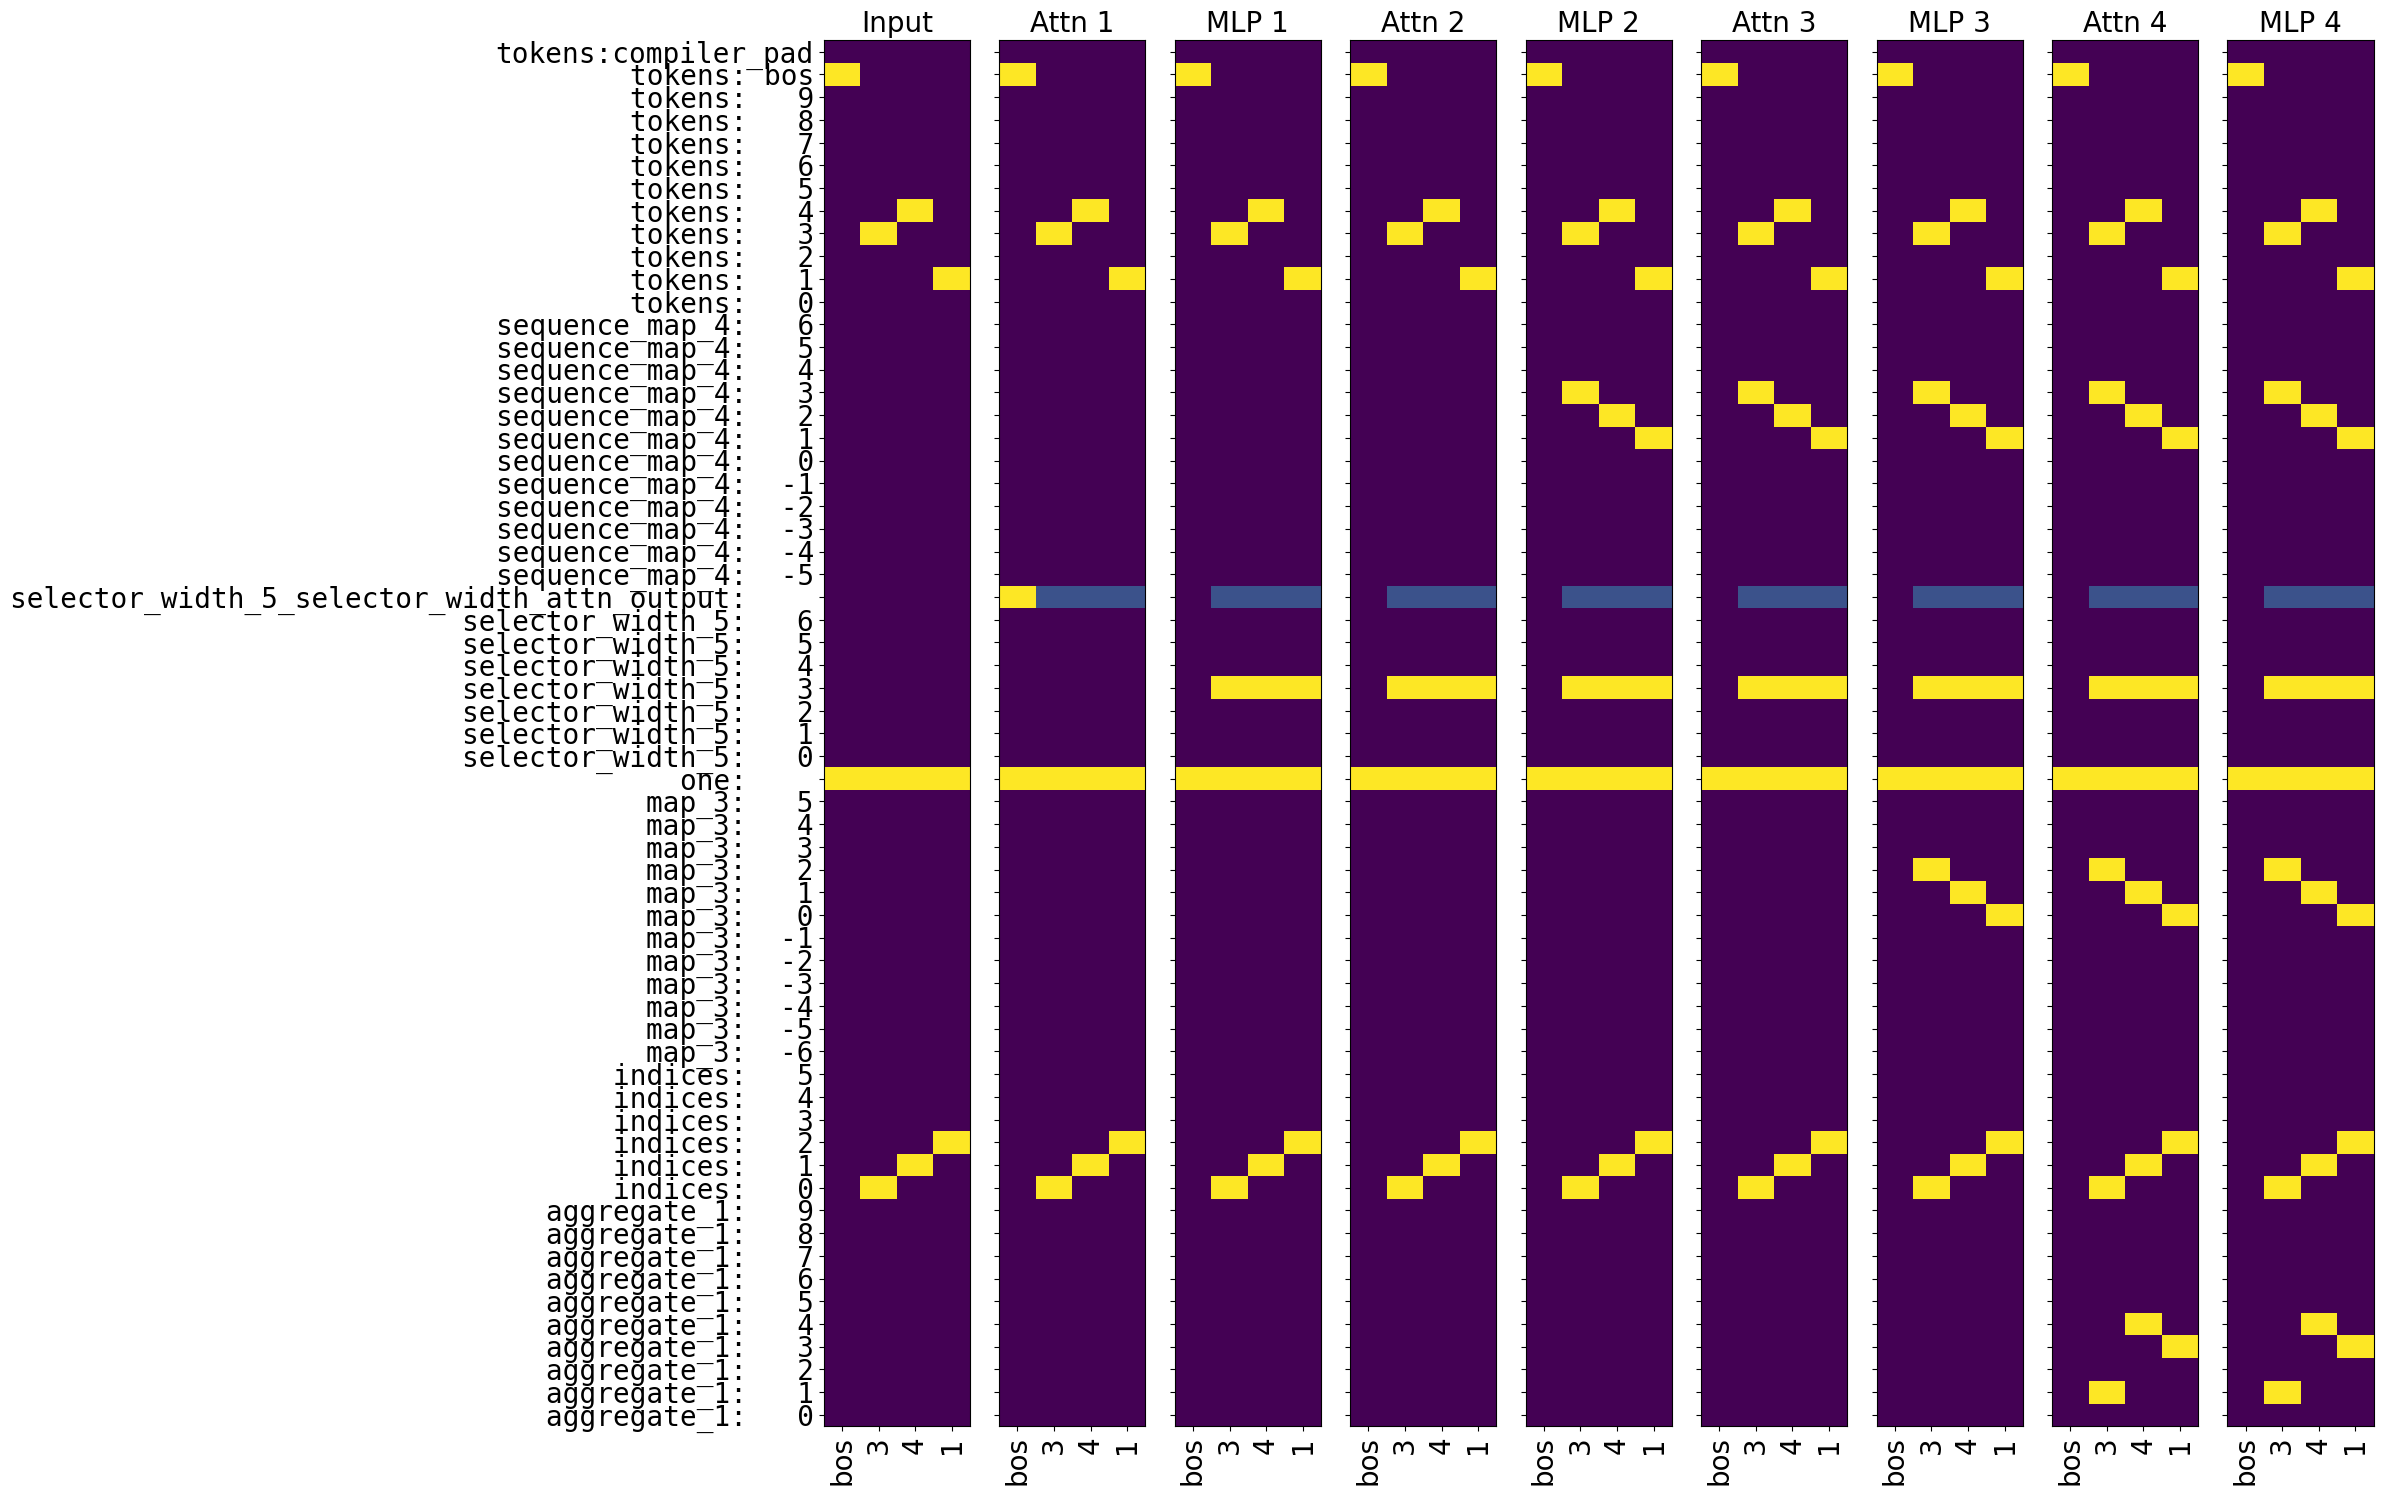

In [19]:
#@title Plot residual stream
plot_residuals_and_input(
  model=compiled_model,
  inputs=["bos", 3, 4, 1],
  figsize=(20,18)
)

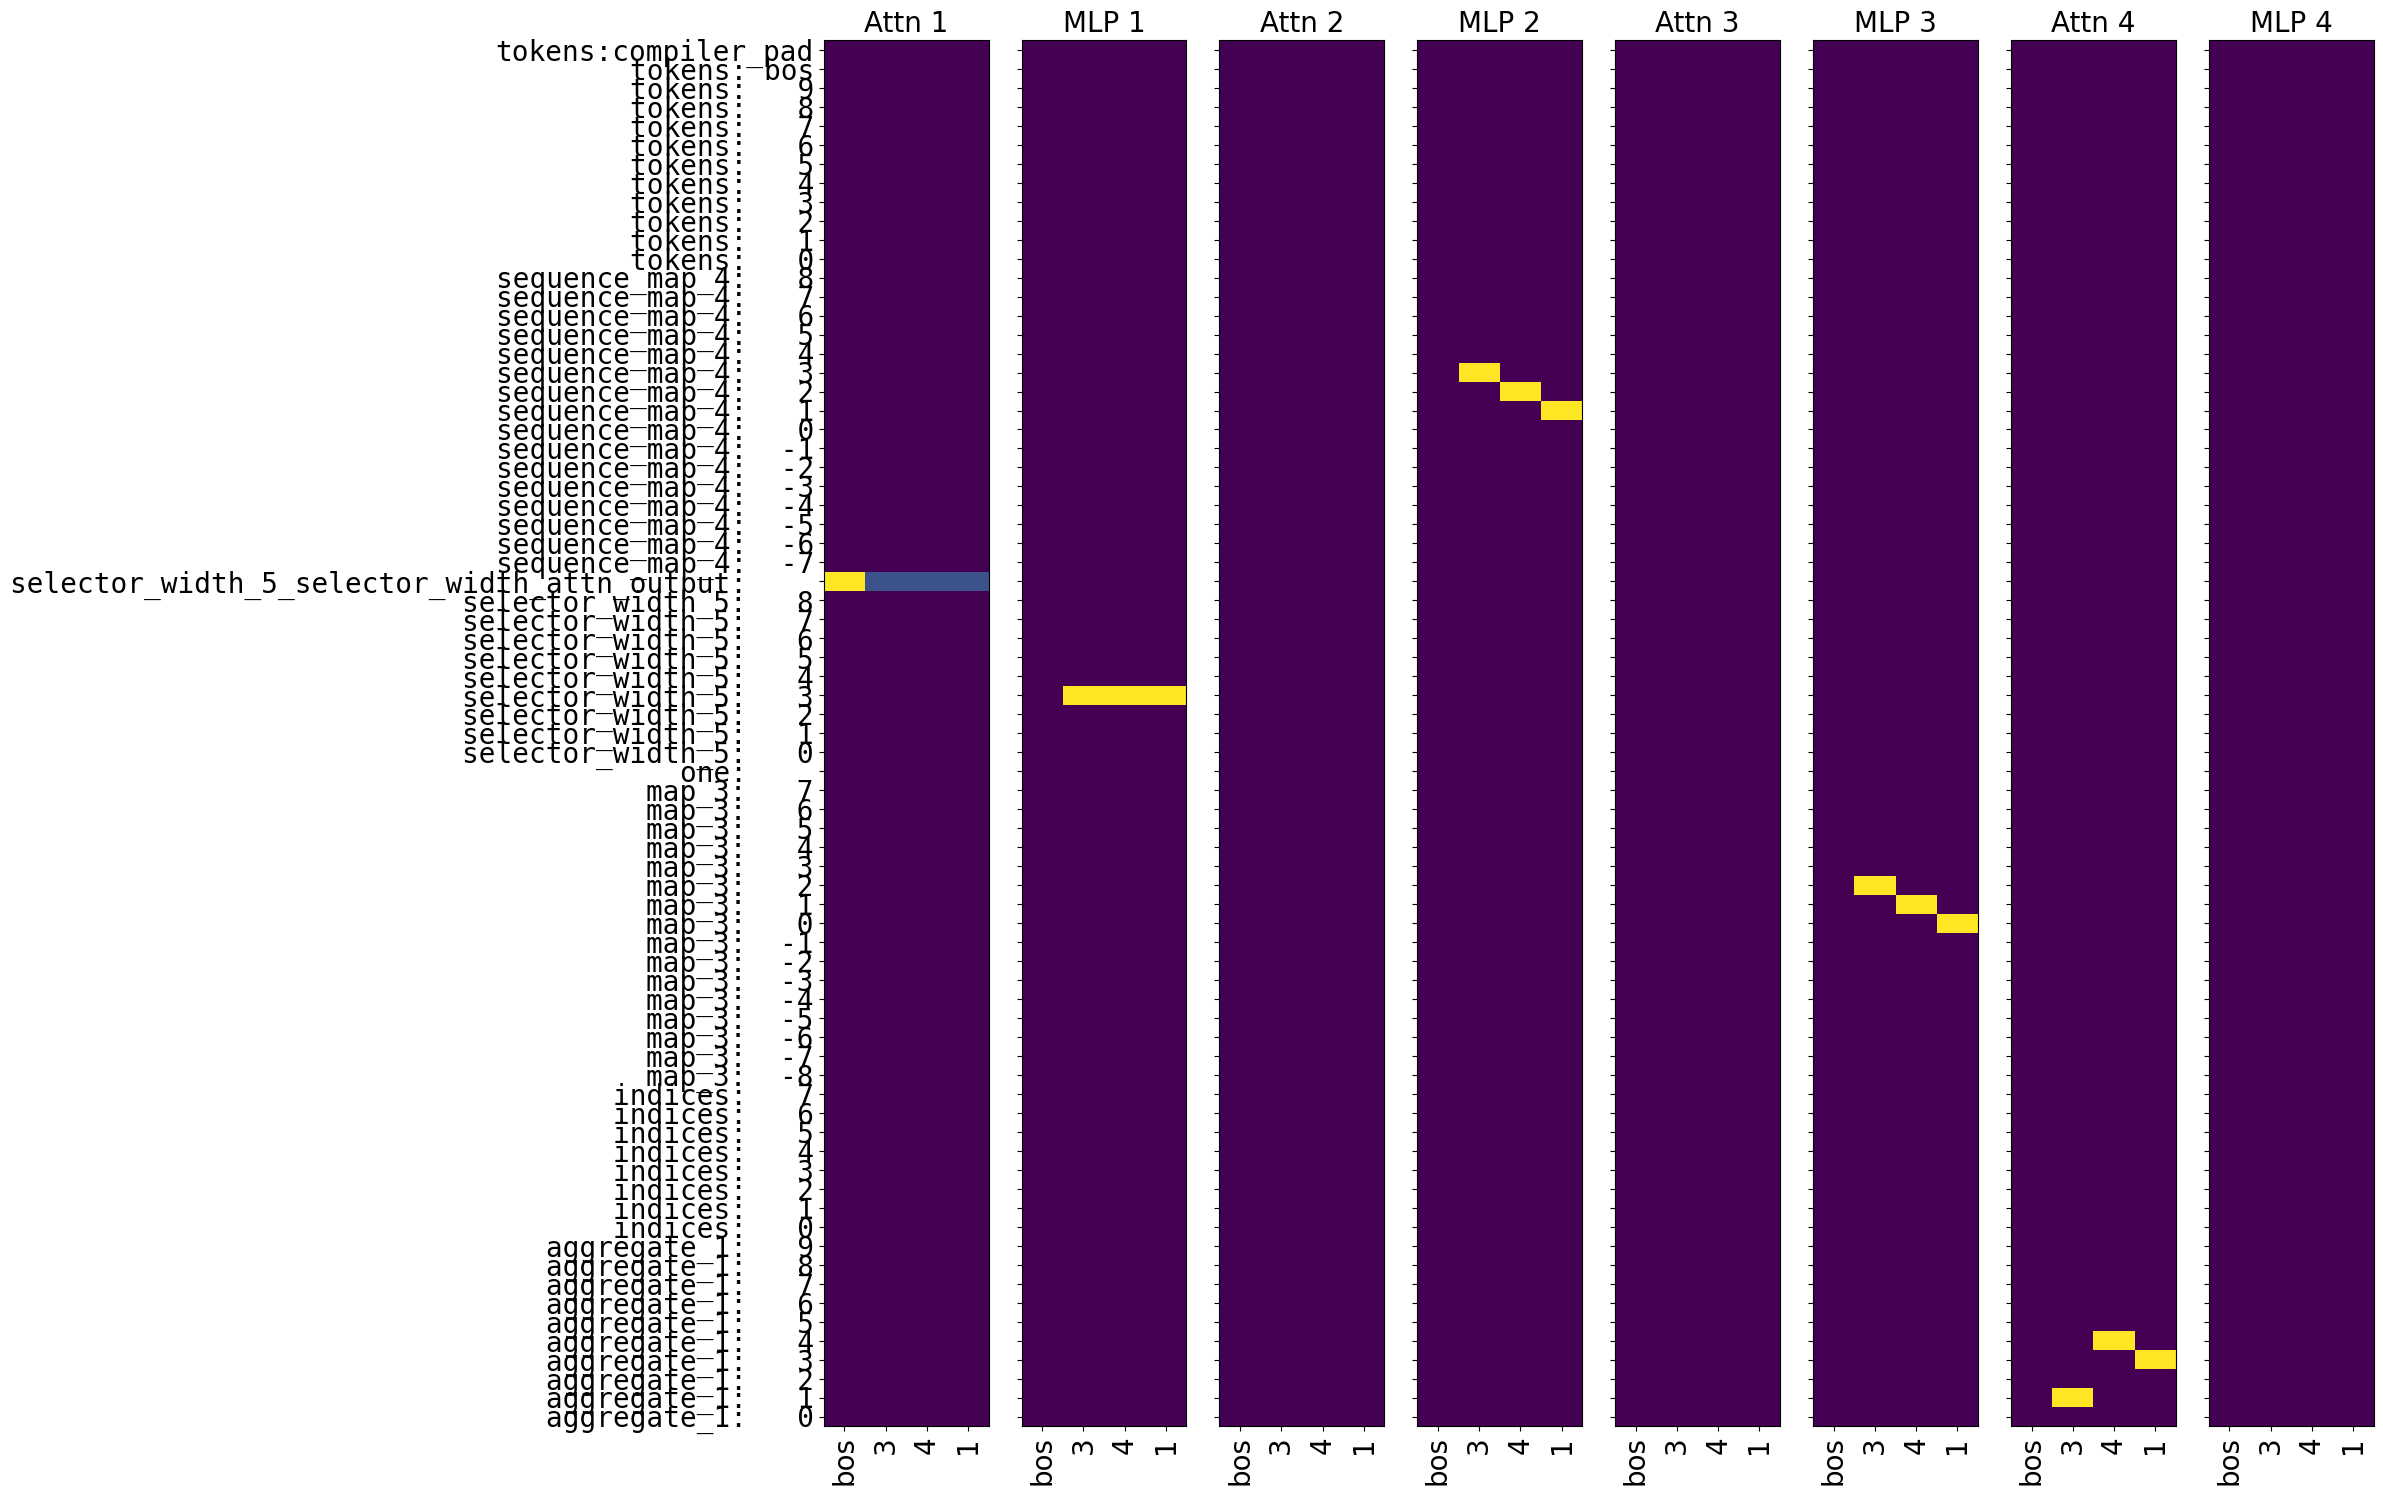

In [12]:
#@title Plot layer outputs
plot_layer_outputs(
  model=compiled_model,
  inputs = ["bos", 3, 4, 1],
  figsize=(20, 18)
)

In [49]:
def make_ones():
    return rasp.SelectorWidth(rasp.Select(rasp.indices, rasp.indices, rasp.Comparison.EQ))

In [41]:
make_ones = make_ones()
make_ones("ellie")

[1, 1, 1, 1, 1]

In [38]:
def hist():
    is_same_selector = rasp.Select(rasp.tokens, rasp.tokens, rasp.Comparison.EQ)
    is_same = rasp.SelectorWidth(is_same_selector)
    return is_same

In [39]:
hist = hist()
hist('ellie')

[2, 2, 2, 1, 2]

In [34]:
def is_match():
    return rasp.tokens=="l"

In [35]:
def make_frac_prevs() -> rasp.SOp:
  """Count the fraction of previous tokens where a specific condition was True.
  Eg:
    num_l("ellie")
    >> [0, 1/2, 2/3, 1/2, 2/5]
  """
  is_match_ = is_match()
  prevs = rasp.Select(rasp.indices, rasp.indices, rasp.Comparison.LEQ)
  return rasp.numerical(rasp.Aggregate(prevs, is_match_))

In [36]:
make_frac_prevs = make_frac_prevs()
make_frac_prevs('ellie')

[0.0, 0.5, 0.6666666666666666, 0.5, 0.4]

In [25]:
def make_sort_unique():
    count_less_than = rasp.Select(rasp.tokens, rasp.tokens, rasp.Comparison.LT)
    positions = rasp.SelectorWidth(count_less_than)
    positions_selector = rasp.Select(positions, rasp.indices, rasp.Comparison.EQ)
    return rasp.Aggregate(positions_selector, rasp.tokens)

In [26]:
make_sort_unique = make_sort_unique()
make_sort_unique([5,4,3,1])

[1.0, 3.0, 4.0, 5.0]

In [22]:
reverse= reverse()